## Modeling: RFM Model for User Segmentation

This notebook aims to compute RFM metrics (Recency, Frequency, and Monetary) to segment users based on their behavior and activity patterns. 

The purpose of this step is to load the dataset and subsetting to only include rows that are about Portuguese attractions.

In [41]:
import pandas as pd
from datetime import datetime
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

datao = pd.read_csv('cleaned_data.csv', delimiter=';')
local_ids = ["MAG010", "MAG014", "MAG021", "MAG032", "MAG047", "MAG049", "MAG093"]
data = datao[datao['localID'].isin(local_ids) ]
# Display the first few rows to understand the structure

print(data.head())

      localID           extractionDate  globalRating  positionOnRanking  \
14153  MAG010  2021-08-20 13:10:44.126           4.0                  6   
14154  MAG010  2021-08-20 13:10:44.173           4.0                  6   
14155  MAG010  2021-08-20 13:10:44.204           4.0                  6   
14156  MAG010  2021-08-20 13:10:44.300           4.0                  6   
14157  MAG010  2021-08-20 13:10:44.340           4.0                  6   

       sitesOnRanking  totalReviews                   userName  \
14153             726         36979                WWH47@WWH47   
14154             726         36979  Runawayblond@runawayblond   
14155             726         36979    Darren H@DarrenHumphrey   
14156             726         36979           Trent B@53trentb   
14157             726         36979           Grendy@Grendy123   

          userLocation  userContributions tripType reviewWritten  \
14153  Baton Rouge, LA                121     Null    2021-08-02   
14154      Chica

The purpose of this step is to calculate the RFM metrics (Recency, Frequency, and Monetary) for each user in the dataset. These metrics provide valuable insights into user behavior:

- `Recency` measures how recently a user has visited a tourist attraction, giving an indication of the interest of the customer over time.

- `Frequency` tracks the number of reviews a user left(how many attractions it visited).

- `Monetary` evaluates the average value of a user's reviews, using the reviewRating column as a proxy. 

This helps to understand the overall quality or significance of the user's interactions.
As a result of this step, a table is created that summarizes user behavior based on these RFM metrics. 

In [42]:
# Compute RFM metrics
# Add a TotalAmount column using reviewRating as a proxy for monetary value
data['reviewVisited'] = pd.to_datetime(data['reviewVisited'], errors='coerce')
data['extractionDate'] = pd.to_datetime(data['extractionDate'], errors='coerce')
dateMax = data['extractionDate'].max()
data['TotalAmount'] = data['reviewRating']

# Group by userName and calculate Recency, Frequency, and Monetary metrics
rfm = data.groupby('userName').agg(
    Recency=('reviewVisited', lambda date: (dateMax - date.max()).days),
    Frequency=('localID', 'count'),
    Monetary=('TotalAmount', 'mean')
).fillna(0)

# Show the first 5 rows of the RFM table
print(rfm.head(5))

C:\Users\laura\AppData\Local\Temp\ipykernel_17084\1139811517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['reviewVisited'] = pd.to_datetime(data['reviewVisited'], errors='coerce')
C:\Users\laura\AppData\Local\Temp\ipykernel_17084\1139811517.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['extractionDate'] = pd.to_datetime(data['extractionDate'], errors='coerce')
C:\Users\laura\AppData\Local\Temp\ipykernel_17084\1139811517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a c

                           Recency  Frequency  Monetary
userName                                               
007JNR@007JNR                  873          1  4.000000
0Garza@0Garza                  567          3  3.666667
101eggie@101eggie              690          1  1.000000
1104@1104                      843          1  5.000000
110Helen2014@110Helen2014      567          1  5.000000


This step is to determine the quartile thresholds for each RFM metric (Recency, Frequency, and Monetary). Using the describe() function, the statistical properties of these metrics are calculated, including their minimum, maximum, and quartile values. 

In [43]:
# Determine RFM quartiles
# Describe the RFM metrics to find quartile thresholds
cols = ['Recency', 'Frequency', 'Monetary']
quartiles = rfm[cols].describe()
print(quartiles)

           Recency    Frequency     Monetary
count  3495.000000  3495.000000  3495.000000
mean    770.499285     1.256366     4.412556
std     165.233847     0.565234     0.885552
min      20.000000     1.000000     1.000000
25%     690.000000     1.000000     4.000000
50%     782.000000     1.000000     5.000000
75%     873.000000     1.000000     5.000000
max    1297.000000     6.000000     5.000000


A scoring system is implemented to assign values from 1 to 4 to each user for the Recency, Frequency, and Monetary metrics based on quartiles. This generates three separate scores— RScore, FScore, and MScore—representing user behavior in each category.

- A "R" score of 1 represents a recent visit whilst a 4 indicates a visit long time ago.

- A "F" score of 1 represents less visits overtime whilst a 4 indicates a more visits.

- A "M" score of 1 represents low ratings from the interactions whilst a 4 indicates hight ratings.

The monetary metric needed the following adjustment, we attributed out of 4: 
- if the average was 2 or less, we attribute 1.
- if the average was below 3, we attribute 2.
- if the average was below 4, we attribute 3.
- if the average was between 4 and 5, we attribute 4.

In [44]:

def RFMScore(x, col=None, custom=False):
    if custom:  
        if x <= 2:
            return '1'
        elif x <= 3:
            return '2'
        elif x <= 4:
            return '3'
        else:
            return '4'
    else:  
        if x <= col.quantile(0.25):
            return '1'
        elif x <= col.quantile(0.5):
            return '2'
        elif x <= col.quantile(0.75):
            return '3'
        else:
            return '4'

# Aplicar a função de scoring às métricas de RFM
rfm['RScore'] = rfm['Recency'].apply(RFMScore, col=rfm['Recency'])
rfm['FScore'] = rfm['Frequency'].apply(RFMScore, col=rfm['Frequency'])
rfm['MScore'] = rfm['Monetary'].apply(RFMScore, custom=True)

# Mostrar as primeiras 5 linhas com os scores de RFM
print(rfm.head(5))


                           Recency  Frequency  Monetary RScore FScore MScore
userName                                                                    
007JNR@007JNR                  873          1  4.000000      3      1      3
0Garza@0Garza                  567          3  3.666667      1      4      3
101eggie@101eggie              690          1  1.000000      1      1      1
1104@1104                      843          1  5.000000      3      1      4
110Helen2014@110Helen2014      567          1  5.000000      1      1      4


Once the individual scores are calculated, they are combined into a single metric called RFMScore. 
The RScore, FScore, and MScore values are first converted into strings and then concatenated to form a three-digit code. For example, a user with a Recency score of 4, a Frequency score of 2, and a Monetary score of 1 would receive an RFMScore of 421. This RFMScore represents the overall behavior of each user across the three metrics and provides a clear classification for segmentation. Users are sorted by their RFMScore to facilitate further analysis.

In [45]:
# Combine RFM scores
# Convert scores to strings and concatenate them to form the RFMScore column
cols = ['RScore','FScore','MScore']
rfm[cols] = rfm[cols].astype(str)
rfm['RFMScore'] = rfm['RScore'] + rfm['FScore'] + rfm['MScore']
# Sort and display customers by RFM score
rfm = rfm.sort_values(by='RFMScore')
print(rfm.head(5))

                     Recency  Frequency  Monetary RScore FScore MScore  \
userName                                                                 
Katryn I@KatrynI         567          1       1.0      1      1      1   
Philip M@921philipm      598          1       2.0      1      1      1   
Janice D@britany52       690          1       2.0      1      1      1   
Jenni@manaaja            416          1       2.0      1      1      1   
YC77@YCLoveTravel        598          1       1.0      1      1      1   

                    RFMScore  
userName                      
Katryn I@KatrynI         111  
Philip M@921philipm      111  
Janice D@britany52       111  
Jenni@manaaja            111  
YC77@YCLoveTravel        111  


To better understand the characteristics of each RFM segment, summary statistics are calculated. Users are grouped by their RFMScore, and key metrics are computed for each segment:

- The total number of customers in the segment (NrCustomers).

- The average Recency, Frequency, and Monetary values for the segment.

- These statistics help identify which segments represent high-value customers and which may require reactivation strategies. 

For example, segments with low Recency scores (indicating recent activity) and high Frequency and Monetary values are likely to include loyal and profitable customers.

In [46]:
# Calculate statistics per RFM segment
RFMStats = rfm.reset_index().groupby(['RFMScore']).agg(
    NrCustomers=('userName', lambda i: len(i.unique())),
    avgRecency=('Recency', 'mean'),
    avgFrequency=('Frequency', 'mean'),
    avgMonetary=('Monetary', 'mean')
).fillna(0)

# Show statistics
print(RFMStats)

          NrCustomers   avgRecency  avgFrequency  avgMonetary
RFMScore                                                     
111                48   560.833333      1.000000     1.333333
112                70   589.200000      1.000000     3.000000
113               161   582.633540      1.000000     4.000000
114               542   586.261993      1.000000     5.000000
141                 1   659.000000      2.000000     2.000000
142                 5   628.800000      2.000000     3.000000
143                51   601.725490      2.156863     3.856209
144               162   590.407407      2.277778     4.784979
211                45   748.244444      1.000000     1.600000
212                73   746.328767      1.000000     3.000000
213               175   750.468571      1.000000     4.000000
214               386   749.313472      1.000000     5.000000
242                 5   738.600000      2.000000     2.900000
243                42   748.047619      2.285714     3.847222
244     

In [47]:
# Check customers in a specific RFM segment
specific_segment = rfm[rfm['RFMScore'] == '112']
print(specific_segment.head())

                           Recency  Frequency  Monetary RScore FScore MScore  \
userName                                                                       
Danilo@danzzzilla              567          1       3.0      1      1      2   
spaceplanner@spaceplanner      690          1       3.0      1      1      2   
LondonKiwi73@LondonKiwi73      659          1       3.0      1      1      2   
Aslanda24@Aslanda24            659          1       3.0      1      1      2   
holiday500@holiday500          690          1       3.0      1      1      2   

                          RFMScore  
userName                            
Danilo@danzzzilla              112  
spaceplanner@spaceplanner      112  
LondonKiwi73@LondonKiwi73      112  
Aslanda24@Aslanda24            112  
holiday500@holiday500          112  


Visualize RFM Segments with a 3D Scatter Plot

A 3D scatter plot is created to visualize the distribution of users based on their Recency, Frequency, and Monetary values. Each metric is plotted on one axis, and the users’ positions in the 3D space reflect their behavior.

To enhance clarity, colors are assigned to represent Recency scores:

- `Green` for users with low Recency (more recent interactions).

- `Yellow` for users with medium Recency.

- `Red` for users with high Recency (less recent interactions).

The scatter plot highlights clusters of users with similar behaviors, helping identify distinct groups based on their RFM values.


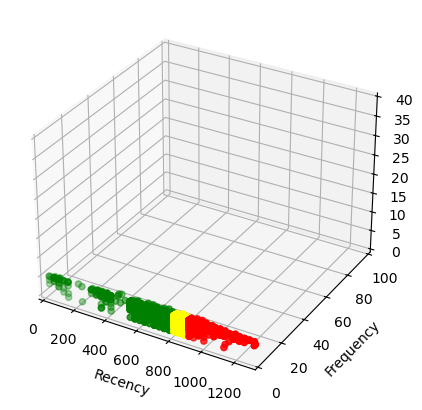

In [54]:


# Draw the 3D scatter plot
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')


color = ['green' if x[0] < '3' else ('yellow' if x[0] == '3' else 'red') for x in rfm['RFMScore']]

# Scatter plot
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=color)

# Set labels
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

# # Set less specific ticks for each axis
# ax.set_xticks(range(0, 1500, 250))  
# ax.set_yticks(range(0, 10, 2))     
# ax.set_zticks(range(0, 10, 2))      

# Adjust axis limits to focus on one chunk of points
ax.set_xlim(0, 1300)  
ax.set_ylim(0, 100)    
ax.set_zlim(0, 40)    

plt.show()


In [49]:
rfm.describe()

,Recency,Frequency,Monetary
count,3495.000000,3495.000000,3495.000000
mean,770.499285,1.256366,4.412556
std,165.233847,0.565234,0.885552
min,20.000000,1.000000,1.000000
25%,690.000000,1.000000,4.000000
50%,782.000000,1.000000,5.000000
75%,873.000000,1.000000,5.000000
max,1297.000000,6.000000,5.000000


We created a treemap of customers by RFM segment in order to know how many customers we have by each segment.

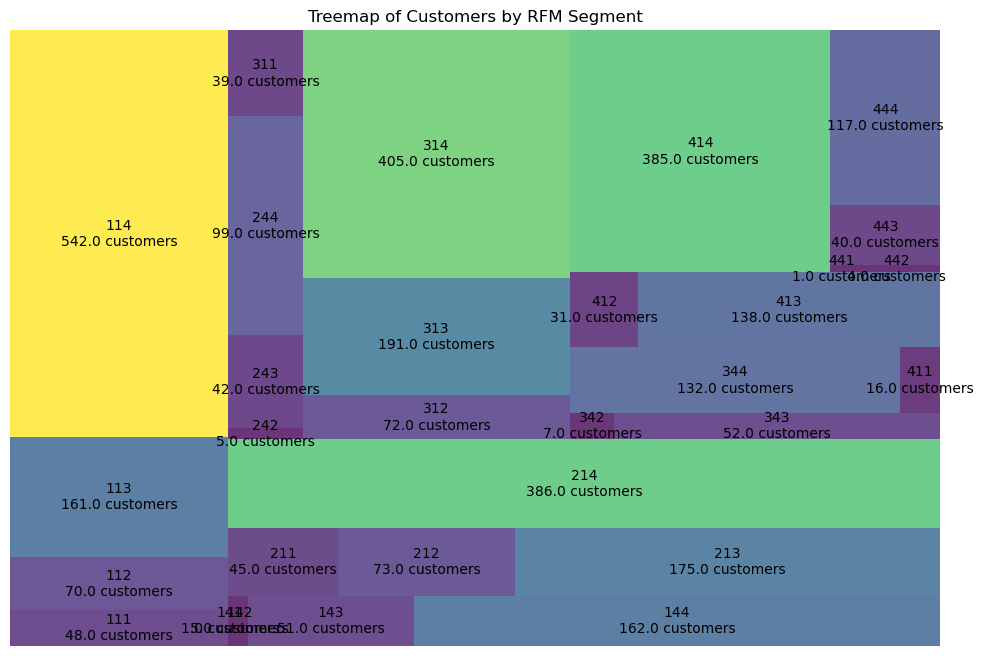

In [50]:


# Treemap for the number of customers by RFM segment
plt.figure(figsize=(12, 8))

# Use RFMStats to get data for the treemap
labels = [f"{index}\n{row['NrCustomers']} customers" for index, row in RFMStats.iterrows()]
sizes = RFMStats['NrCustomers']
colors = plt.cm.viridis(sizes / sizes.max())

# Create the treemap
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)
plt.title('Treemap of Customers by RFM Segment')
plt.axis('off')
plt.show()

The folowing treemap visualizes the size and distribution of customer segments based on their RFM scores. Each rectangle represents a segment, with its size proportional to the number of customers in that group. Colors are assigned based on the segment's category: Gold for strong-performing segments (e.g., 142), Silver for mid-tier (e.g., 141), and Bronze for lower-performing segments (e.g., 112).



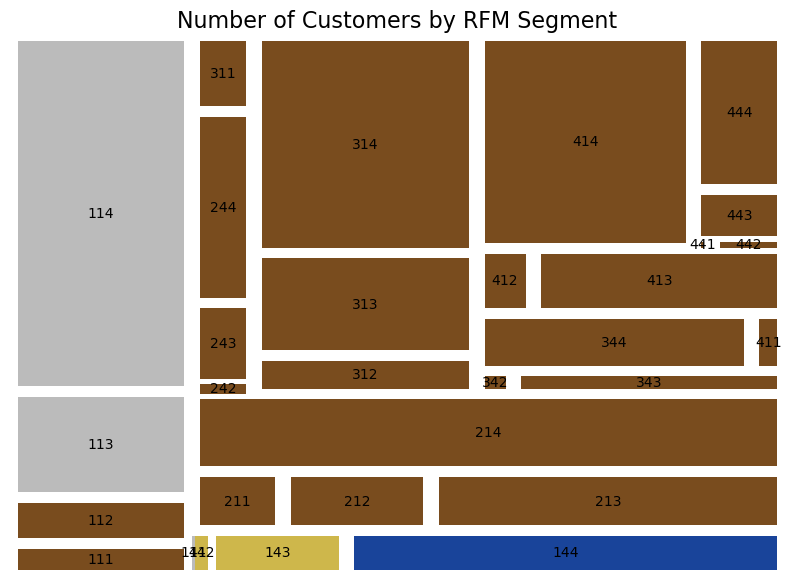

In [55]:


# Define colors for RFM segments
def assignColor(rfm):
    if rfm == '144':
        return '#00308F'  # Platinum
    elif rfm in ['142', '143', '133', '134', '124']:
        return '#C9B037'  # Gold
    elif rfm in ['141', '131', '132', '122', '123', '113', '114']:
        return '#B4B4B4'  # Silver
    else:
        return '#6A3805'  # Bronze

# Generate colors for each RFM segment
colors = [assignColor(segment) for segment in RFMStats.index]

# Draw the treemap
plt.figure(figsize=(10, 7))
squarify.plot(
    sizes=RFMStats['NrCustomers'],  
    label=RFMStats.index,           
    color=colors,                   
    alpha=0.9,                     
    pad=True                       
)

# Add title and remove axes
plt.title("Number of Customers by RFM Segment", fontsize=16)
plt.axis('off')  
plt.show()

To understand the how the monetary varied between each RFM score we created the following heatmap.

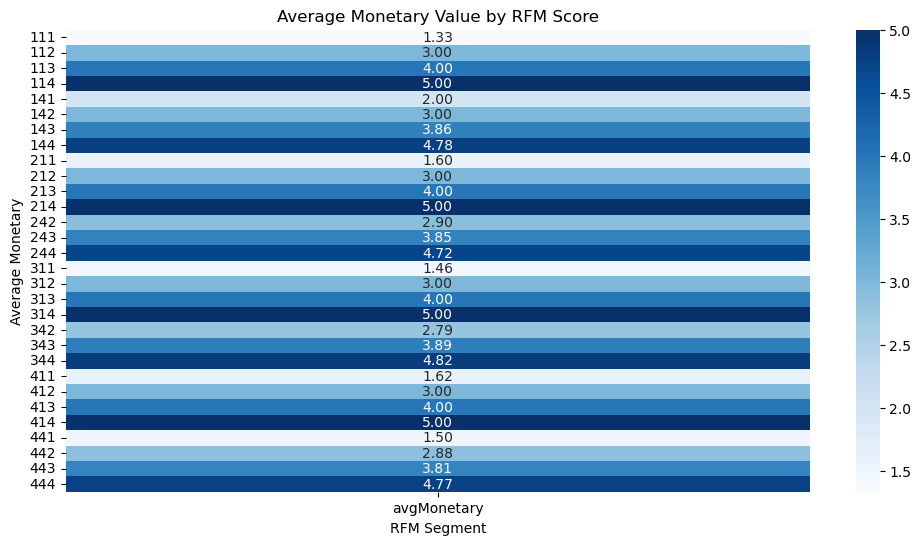

In [52]:
# Pivot table for heatmap
heatmap_data = RFMStats.pivot_table(values='avgMonetary', index='RFMScore', columns=None, aggfunc='mean').fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.title('Average Monetary Value by RFM Score')
plt.xlabel('RFM Segment')
plt.ylabel('Average Monetary')
plt.show()